Connect with GDM CPU/GPU/TPU runtime

# Import

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import jacobian
from jax import jacfwd, jacrev

from jax import vjp, jvp

# Quick Start

In [ ]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(5.0)
print(x, selu(x))

[0. 1. 2. 3. 4.] [0.        1.05      2.1       3.1499999 4.2      ]


In [ ]:
key = random.key(1701)
x = random.normal(key, (1_000_000,))
%timeit selu(x).block_until_ready()

The slowest run took 15883.98 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 5: 256 µs per loop


In [ ]:
selu_jit = jit(selu)
_ = selu_jit(x)  # compiles on first call
%timeit selu_jit(x).block_until_ready()

The slowest run took 4.16 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 5: 83 µs per loop


In [ ]:
def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
derivative_fn_jit=jit(derivative_fn)
print(derivative_fn_jit(x_small))

[0.25       0.1966118  0.10499343]


In [ ]:
x_small = jnp.arange(3.)
print(x_small)
print(jacobian(jnp.exp)(x_small))
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

[0. 1. 2.]
[[1.        0.        0.       ]
 [0.        2.71828   0.       ]
 [0.        0.        7.3890476]]
-0.03532532


In [ ]:
from jax import jacfwd, jacrev
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))
print(hessian(sum_logistic)(x_small))

[[-0.         -0.         -0.        ]
 [-0.         -0.09085784 -0.        ]
 [-0.         -0.         -0.07996242]]


In [ ]:
key1, key2 = random.split(key)
mat = random.normal(key1, (150, 100))
batched_x = random.normal(key2, (10, 100))

def apply_matrix(x):
  return jnp.dot(mat, x)


In [ ]:
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
The slowest run took 3102.01 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 5: 1.11 ms per loop


In [ ]:
import numpy as np

@jit
def batched_apply_matrix(batched_x):
  return jnp.dot(batched_x, mat.T)

# np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
#                            batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
The slowest run took 10102.79 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 5: 67.2 µs per loop


In [ ]:
from jax import vmap

@jit
def vmap_batched_apply_matrix(batched_x):
  return vmap(apply_matrix)(batched_x)

# np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
#                            vmap_batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
The slowest run took 12914.65 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 5: 64.2 µs per loop


# Key Concepts

https://jax.readthedocs.io/en/latest/key-concepts.html#

## jax.Array

In [ ]:
# jax.numpy.zeros()
# jax.numpy.linspace()
# jax.numpy.arange()

x = jnp.ones(5)
print(x)
isinstance(x, jax.Array)
# inspect where the contents of the array are stored
print(x.devices())
print(x.sharding)

[1. 1. 1. 1. 1.]
{TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)}
SingleDeviceSharding(device=TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), memory_kind=device)


## Transformations
functions to operate on arrays, e.g., jit, vmap, grad, etc

In [ ]:
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jax.jit(selu)
print(selu_jit(1.0))

# Equal to
@jax.jit
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

{TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)}

## Tracing

Trace the sequence of operations performed by a Python function

In [ ]:
# see tracing by printing any array value within transformed JAX code
@jax.jit
def f(x):
  print(x)
  return x + 1

x = jnp.arange(5)
result = f(f(x))
print(x)
print(result)

Traced<ShapedArray(int32[5])>with<DynamicJaxprTrace>
[0 1 2 3 4]
[2 3 4 5 6]


## Jaxprs

- a simple representation of primitive operations
- if we have a Python conditional, the jaxpr will only know about the branch we take

In [ ]:
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(5.0)
jax.make_jaxpr(selu)(x)

{ lambda ; a:f32[5]. let
    b:bool[5] = gt a 0.0
    c:f32[5] = exp a
    d:f32[5] = mul 1.6699999570846558 c
    e:f32[5] = sub d 1.6699999570846558
    f:f32[5] = pjit[
      name=_where
      jaxpr={ lambda ; g:bool[5] h:f32[5] i:f32[5]. let
          j:f32[5] = select_n g i h
        in (j,) }
    ] b a e
    k:f32[5] = mul 1.0499999523162842 f
  in (k,) }

## Pytrees

- structure for handling collections of params
- jax.tree lib

In [ ]:
# (nested) list of parameters
params = [1, 2, (jnp.arange(3), jnp.ones(2))]
print(params)

print(jax.tree.structure(params))
print(jax.tree.leaves(params))

[1, 2, (Array([0, 1, 2], dtype=int32), Array([1., 1.], dtype=float32))]
PyTreeDef([*, *, (*, *)])
[1, 2, Array([0, 1, 2], dtype=int32), Array([1., 1.], dtype=float32)]


In [ ]:
# Dictionary of parameters
params = {'n': 5, 'W': jnp.ones((2, 2)), 'b': jnp.zeros(2)}

print(jax.tree.structure(params))
print(jax.tree.leaves(params))

PyTreeDef({'W': *, 'b': *, 'n': *})
[Array([[1., 1.],
       [1., 1.]], dtype=float32), Array([0., 0.], dtype=float32), 5]


In [ ]:
# Named tuple of parameters
from typing import NamedTuple

class Params(NamedTuple):
  a: int
  b: float

params = Params(1, 5.0)
print(jax.tree.structure(params))
print(jax.tree.leaves(params))

PyTreeDef(CustomNode(namedtuple[Params], [*, *]))
[1, 5.0]


# Just-in-time (jit) Compilation

In [ ]:
# The code above is sending one operation at a time to the accelerator.
# This limits the ability of the XLA compiler to optimize our functions.
def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

The slowest run took 10135.66 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 5: 252 µs per loop


In [ ]:
# compiled version of selu
selu_jit = jax.jit(selu)

# Pre-compile the function before timing...
# if we don't have this line, timer will count the pre-compiling time too
selu_jit(x).block_until_ready()

%timeit selu_jit(x).block_until_ready()

The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 5: 71.7 µs per loop


In [ ]:
# While loop conditioned on x and n.

def g(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

jax.jit(g)(10, 20)  # Raises an error
# Traced values within JIT, like x and n here, can only affect control flow via
# their static attributes: such as shape or dtype, and not via their values.

In [ ]:
@jax.jit
def f(x, i):
  return x + i

def g(x, n):
  i = 0
  while i < n:
    i += 1
  return f(x,i)

print(g(2, 10))

12


In [ ]:
# Solution 1: Need to split them into two steps
# While loop conditioned on x and n with a jitted body.

@jax.jit
def loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted(x, n):
  i = 0
  while i < n:
    i = loop_body(i)
  return x + i

g_inner_jitted(10, 20)

Array(30, dtype=int32, weak_type=True)

In [ ]:
# Solution 2: Marking arguments as static
# cons: JAX will have to re-compile the function for every new value of the specified static input

def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

f_jit_correct = jax.jit(f, static_argnums=0)
print(f_jit_correct(1))

def g(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

g_jit_correct = jax.jit(g, static_argnames=['n'])
print(g_jit_correct(10, 20))

from functools import partial

@partial(jax.jit, static_argnames=['n'])
def g_jit_decorated(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

print(g_jit_decorated(10, 20))

1
30


In [ ]:
# Caching

from functools import partial

def unjitted_loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted_partial(x, n):
  i = 0
  while i < n:
    # Don't do this! each time the partial returns
    # a function with different hash
    i = jax.jit(partial(unjitted_loop_body))(i)
  return x + i

def g_inner_jitted_lambda(x, n):
  i = 0
  while i < n:
    # Don't do this!, lambda will also return
    # a function with a different hash
    i = jax.jit(lambda x: unjitted_loop_body(x))(i)
  return x + i

def g_inner_jitted_normal(x, n):
  i = 0
  while i < n:
    # this is OK, since JAX can find the
    # cached, compiled function
    i = jax.jit(unjitted_loop_body)(i)
  return x + i

print("jit called in a loop with partials:")
%timeit g_inner_jitted_partial(10, 20).block_until_ready()

print("jit called in a loop with lambdas:")
%timeit g_inner_jitted_lambda(10, 20).block_until_ready()

print("jit called in a loop with caching:")
%timeit g_inner_jitted_normal(10, 20).block_until_ready()

jit called in a loop with partials:
1 loops, best of 5: 14.9 s per loop
jit called in a loop with lambdas:
1 loops, best of 5: 10.5 s per loop
jit called in a loop with caching:
The slowest run took 63.21 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 5: 5.39 ms per loop


# Automatic Vectorization

In [ ]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

# not efficient
def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

manually_batched_convolve(xs, ws)

# efficient
auto_batch_convolve = jax.vmap(convolve)
auto_batch_convolve(xs, ws)

# If the batch dimension is not the first, you may use the in_axes and out_axes
# arguments to specify the location of the batch dimension in inputs and
# outputs. These may be an integer if the batch axis is the same for all inputs
# and outputs, or lists, otherwise.
auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)
xst = jnp.transpose(xs)
wst = jnp.transpose(ws)
auto_batch_convolve_v2(xst, wst)

# also supports the case where only one of the arguments is batched
batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])
batch_convolve_v3(xs, w)

# jax.jit() and jax.vmap() are designed to be composable
jitted_batch_convolve = jax.jit(auto_batch_convolve)
jitted_batch_convolve(xs, ws)

Array([[11., 11.],
       [20., 20.],
       [29., 29.]], dtype=float32)

# Automatic Differentiation

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.key(0)

In [ ]:
# @title Taking gradinets with jax.grad

import jax
import jax.numpy as jnp
from jax import grad

grad_tanh = grad(jnp.tanh)
print(grad_tanh(2.0))

print(grad(grad(jnp.tanh))(2.0))
print(grad(grad(grad(jnp.tanh)))(2.0))

f = lambda x: x**3 + 2*x**2 - 3*x + 1
dfdx = jax.grad(f)
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)

0.07060704
-0.13613746
0.25251603


In [ ]:
# @title Taking gradients part 2
# f: R^n => R^m
# jax.jacfwd is more effcient when n << m
# jax.jacrev is more efficient when m << n
# They give the same answer.

In [ ]:
def hessian(f):
  return jax.jacfwd(jax.grad(f))

In [ ]:
def f(x):
  return jnp.dot(x, x)

hessian(f)(jnp.array([1., 2., 3.]))

Array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]], dtype=float32)

In [ ]:
# Some meta-learning techniques, such as Model-Agnostic Meta-Learning (MAML),
# require differentiating through gradient updates. In other frameworks this can
# be quite cumbersome, but in JAX it’s much easier
# TODO: ?
def meta_loss_fn(params, data):
  """Computes the loss after one step of SGD."""
  grads = jax.grad(loss_fn)(params, data)
  return loss_fn(params - lr * grads, data)

# meta_grads = jax.grad(meta_loss_fn)(params, data)

In [ ]:
# @title Computing gradients in a linear regression
# linear logistic regression model example
key = jax.random.key(0)

def sigmoid(x):
  return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
  return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                    [0.88, -1.08, 0.15],
                    [0.52, 0.06, -1.30],
                    [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])

# Training loss is the negative log-likelihood of the training examples.
def loss(W, b):
  preds = predict(W, b, inputs)
  label_probs = preds * targets + (1 - preds) * (1 - targets)
  return -jnp.sum(jnp.log(label_probs))

# Initialize random model coefficients
key, W_key, b_key = jax.random.split(key, 3)
W = jax.random.normal(W_key, (3,))
b = jax.random.normal(b_key, ())

# Differentiate `loss` with respect to the first positional argument:
W_grad = grad(loss, argnums=0)(W, b)
print(f'{W_grad=}')

# Since argnums=0 is the default, this does the same thing:
W_grad = grad(loss)(W, b)
print(f'{W_grad=}')

# But you can choose different values too, and drop the keyword:
b_grad = grad(loss, 1)(W, b)
print(f'{b_grad=}')

# Including tuple values
W_grad, b_grad = grad(loss, (0, 1))(W, b)
print(f'{W_grad=}')
print(f'{b_grad=}')

W_grad=Array([-0.16966598, -0.8774322 , -1.4901515 ], dtype=float32)
W_grad=Array([-0.16966598, -0.8774322 , -1.4901515 ], dtype=float32)
b_grad=Array(-0.29228413, dtype=float32)
W_grad=Array([-0.16966598, -0.8774322 , -1.4901515 ], dtype=float32)
b_grad=Array(-0.29228413, dtype=float32)


In [ ]:
# @title Differentiating with respect to nested lists, tuples, and dicts

def loss2(params_dict):
    preds = predict(params_dict['W'], params_dict['b'], inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.sum(jnp.log(label_probs))

print(grad(loss2)({'W': W, 'b': b}))

In [ ]:
# @title Evaluating a function and its gradient using jax.value_and_grad

loss_value, Wb_grad = jax.value_and_grad(loss, (0, 1))(W, b)
print('loss value', loss_value)
print('loss value', loss(W, b))

In [ ]:
# @title Checking against numberical differences (finite differences)

# Set a step size for finite differences calculations
eps = 1e-4

# Check b_grad with scalar finite differences
b_grad_numerical = (loss(W, b + eps / 2.) - loss(W, b - eps / 2.)) / eps
print('b_grad_numerical', b_grad_numerical)
print('b_grad_autodiff', grad(loss, 1)(W, b))

# Check W_grad with finite differences in a random direction
key, subkey = jax.random.split(key)
vec = jax.random.normal(subkey, W.shape)
unitvec = vec / jnp.sqrt(jnp.vdot(vec, vec))
W_grad_numerical = (loss(W + eps / 2. * unitvec, b) - loss(W - eps / 2. * unitvec, b)) / eps
print('W_dirderiv_numerical', W_grad_numerical)
print('W_dirderiv_autodiff', jnp.vdot(grad(loss)(W, b), unitvec))


# doing the same thing using test util

from jax.test_util import check_grads
# check_grads(loss, (W, b), order=2)  # check up to 2nd order derivatives

b_grad_numerical -0.26226044
b_grad_autodiff -0.29228413
W_dirderiv_numerical 0.17166138
W_dirderiv_autodiff 0.1800164


## Higher-order optimization

In [ ]:
# @title Stopping gradients

# Value function and initial parameters
# value = theta * state
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

# An example transition.
s_tm1 = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0.])

# grad(theta) = (r_t + v_theta(s_t)) * grad(v_theta(s_(t-1)))
# pseudo loss function
# But the gradient computation will include the dependency of target on theta in this implementation.
def td_loss(theta, s_tm1, r_t, s_t):
  v_tm1 = value_fn(theta, s_tm1)
  target = r_t + value_fn(theta, s_t)
  return -0.5 * ((target - v_tm1) ** 2)

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

delta_theta

# Solution
def td_loss(theta, s_tm1, r_t, s_t):
  v_tm1 = value_fn(theta, s_tm1)
  target = r_t + value_fn(theta, s_t)
  #  force JAX to ignore the dependency of the target on theta
  return -0.5 * ((jax.lax.stop_gradient(target) - v_tm1) ** 2)

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

delta_theta

s_grad = jax.grad(value_fn)(theta, s_tm1)
delta_theta_original_calculation = (r_t + value_fn(theta, s_t) - value_fn(theta, s_tm1)) * s_grad

delta_theta_original_calculation # [1.2, 2.4, -1.2], same as `delta_theta`

Array([ 1.2,  2.4, -1.2], dtype=float32)

In [ ]:
# @title Straight-through estimator using stop_gradient
def f(x):
  return jnp.round(x)  # non-differentiable

def straight_through_f(x):
  # Create an exactly-zero expression with Sterbenz lemma that has
  # an exactly-one gradient.
  zero = x - jax.lax.stop_gradient(x)
  return zero + jax.lax.stop_gradient(f(x))

print("f(x): ", f(3.2))
print("straight_through_f(x):", straight_through_f(3.2))

print("grad(f)(x):", jax.grad(f)(3.2))
print("grad(straight_through_f)(x):", jax.grad(straight_through_f)(3.2))

f(x):  3.0
straight_through_f(x): 3.0
grad(f)(x): 0.0
grad(straight_through_f)(x): 1.0


In [ ]:
# @title Per-example gradients
perex_grads = jax.jit(jax.vmap(jax.grad(td_loss), in_axes=(None, 0, 0, 0)))

# Test it:
batched_s_tm1 = jnp.stack([s_tm1, s_tm1])
batched_r_t = jnp.stack([r_t, r_t])
batched_s_t = jnp.stack([s_t, s_t])

print("per-example grads: ", perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t))

# Step by step
# computes the gradient of the loss w.r.t. the parameters on single (unbatched) inputs:
dtdloss_dtheta = jax.grad(td_loss)
dtdloss_dtheta(theta, s_tm1, r_t, s_t)
almost_perex_grads = jax.vmap(dtdloss_dtheta)
batched_theta = jnp.stack([theta, theta])
print("\nalmost_perex_grads: ", almost_perex_grads(batched_theta, batched_s_tm1, batched_r_t, batched_s_t))
# This makes the resulting function add an extra axis only to the other
# arguments, leaving theta unbatched, as we want:
inefficient_perex_grads = jax.vmap(dtdloss_dtheta, in_axes=(None, 0, 0, 0))
print("\ninefficient_perex_grads: ", inefficient_perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t))
# jit to acclerate
perex_grads = jax.jit(inefficient_perex_grads)
print("\nperex_grads: ", perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t))

%timeit inefficient_perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t).block_until_ready()
%timeit perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t).block_until_ready()

per-example grads:  [[ 1.2  2.4 -1.2]
 [ 1.2  2.4 -1.2]]

almost_perex_grads:  [[ 1.2  2.4 -1.2]
 [ 1.2  2.4 -1.2]]

inefficient_perex_grads:  [[ 1.2  2.4 -1.2]
 [ 1.2  2.4 -1.2]]

perex_grads:  [[ 1.2  2.4 -1.2]
 [ 1.2  2.4 -1.2]]
100 loops, best of 5: 4.68 ms per loop
The slowest run took 7.97 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 5: 63.3 µs per loop


In [ ]:
# @title Hessian-vector products with jax.grad-of-jax.grad
# d2f/d2x * v
def hvp(f, x, v):
    return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)

In [ ]:
# @title Jacobians and Hessians using jax.jacfwd and jax.jacrev

from jax import jacfwd, jacrev
key = random.key(0)

# Define a sigmoid function.
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])

# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

# More efficient for tall Jacobian matrix
J = jacfwd(f)(W)
print("jacfwd result, with shape", J.shape)
print(J)

# More efficient for wide jacobian matrix
J = jacrev(f)(W)
print("jacrev result, with shape", J.shape)
print(J)

# You can also use jax.jacfwd() and jax.jacrev() with container types:
def predict_dict(params, inputs):
    return predict(params['W'], params['b'], inputs)

J_dict = jacrev(predict_dict)({'W': W, 'b': b}, inputs)
for k, v in J_dict.items():
    print("Jacobian from {} to logits is".format(k))
    print(v)

jacfwd result, with shape (4, 3)
[[ 0.05976408  0.12851527  0.08852274]
 [ 0.04011315 -0.04920547  0.00686381]
 [ 0.12177273  0.01407711 -0.30397403]
 [ 0.00140856 -0.00473993  0.00265317]]
jacrev result, with shape (4, 3)
[[ 0.05986786  0.1287384   0.08867645]
 [ 0.04012585 -0.04922104  0.00686598]
 [ 0.12176514  0.01407623 -0.30395508]
 [ 0.00140816 -0.00473857  0.00265241]]
Jacobian from W to logits is
[[ 0.05986786  0.1287384   0.08867645]
 [ 0.04012585 -0.04922104  0.00686598]
 [ 0.12176514  0.01407623 -0.30395508]
 [ 0.00140816 -0.00473857  0.00265241]]
Jacobian from b to logits is
[0.11503464 0.04563986 0.23438963 0.0019079 ]


In [ ]:
def hessian(f):
  # most efficient implementation
  # f: Rn->Rm (n>>m), jacrev(f) more efficient
  # jac(f): mxn
  # jac(jac(f)): (mxn) x n  (n << mxn) jacfwd(f) more efficient
    return jacfwd(jacrev(f))

H = hessian(f)(W)
print("hessian, with shape", H.shape)
print(H)

hessian, with shape (4, 3, 3)
[[[ 0.02283096  0.04895973  0.03373909]
  [ 0.04909515  0.10528183  0.07255173]
  [ 0.03381729  0.0725193   0.04997444]]

 [[-0.03197193  0.03905296 -0.00544488]
  [ 0.0392189  -0.04790497  0.00667906]
  [-0.00547075  0.0066824  -0.00093168]]

 [[-0.01579142 -0.00183123  0.03957367]
  [-0.00182551 -0.00021169  0.00457478]
  [ 0.03941917  0.0045712  -0.0987854 ]]

 [[-0.00103641  0.00349224 -0.00194889]
  [ 0.00348759 -0.01175165  0.00655818]
  [-0.00195217  0.00657797 -0.00367093]]]


## How it’s made: Two foundational autodiff functions

In [ ]:
# @title Jacobian-Vector products (JVPs, a.k.a. forward-mode autodiff)

from jax import jvp

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

key, subkey = random.split(key)
v = random.normal(subkey, W.shape)

# Push forward the vector `v` along `f` evaluated at `W`
y, u = jvp(f, (W,), (v,))

# the FLOP cost of the jvp-transformed function is about 3x the cost of just evaluating the function
# build a column at a time

In [ ]:
# @title Vector-Jacobian products (VJPs, a.k.a. reverse-mode autodiff)
# build one row at a time

from jax import vjp

# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

y, vjp_fun = vjp(f, W)

key, subkey = random.split(key)
u = random.normal(subkey, y.shape)

# Pull back the covector `u` along `f` evaluated at `W`
v = vjp_fun(u)



In [ ]:
# @title Vector-valued gradients with VJPs
def vgrad(f, x):
  y, vjp_fn = vjp(f, x)
  return vjp_fn(jnp.ones(y.shape))[0]

print(vgrad(lambda x: 3*x**2, jnp.ones((2, 2))))

In [ ]:
# @title Hessian-vector products using both forward- and reverse-mode

def hvp(f, x, v):
    return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)


# forward-over-reverse
def hvp(f, primals, tangents):
  return jvp(grad(f), primals, tangents)[1]

def f(X):
  return jnp.sum(jnp.tanh(X)**2)

key, subkey1, subkey2 = random.split(key, 3)
X = random.normal(subkey1, (30, 40))
V = random.normal(subkey2, (30, 40))

ans1 = hvp(f, (X,), (V,))
ans2 = jnp.tensordot(hessian(f)(X), V, 2)

print(jnp.allclose(ans1, ans2, 1e-4, 1e-4))

# Reverse-over-forward
def hvp_revfwd(f, primals, tangents):
  g = lambda primals: jvp(f, primals, tangents)[1]
  return grad(g)(primals)

# Reverse-over-reverse, only works for single arguments
def hvp_revrev(f, primals, tangents):
  x, = primals
  v, = tangents
  return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)


print("Forward over reverse")
%timeit -n10 -r3 hvp(f, (X,), (V,))
print("Reverse over forward")
%timeit -n10 -r3 hvp_revfwd(f, (X,), (V,))
print("Reverse over reverse")
%timeit -n10 -r3 hvp_revrev(f, (X,), (V,))

print("Naive full Hessian materialization")
%timeit -n10 -r3 jnp.tensordot(hessian(f)(X), V, 2)

## Composing VJPs, JVPs, and jax.vmap

In [ ]:
# @title Jacobian-Matrix and Matrix-Jacobian products
# Isolate the function from the weight matrix to the predictions
f = lambda W: predict(W, b, inputs)

# Pull back the covectors `m_i` along `f`, evaluated at `W`, for all `i`.
# First, use a list comprehension to loop over rows in the matrix M.
def loop_mjp(f, x, M):
    y, vjp_fun = vjp(f, x)
    return jnp.vstack([vjp_fun(mi) for mi in M])

# Now, use vmap to build a computation that does a single fast matrix-matrix
# multiply, rather than an outer loop over vector-matrix multiplies.
def vmap_mjp(f, x, M):
    y, vjp_fun = vjp(f, x)
    outs, = vmap(vjp_fun)(M)
    return outs

key = random.key(0)
num_covecs = 128
U = random.normal(key, (num_covecs,) + y.shape)

loop_vs = loop_mjp(f, W, M=U)
print('Non-vmapped Matrix-Jacobian product')
%timeit -n10 -r3 loop_mjp(f, W, M=U)

print('\nVmapped Matrix-Jacobian product')
vmap_vs = vmap_mjp(f, W, M=U)
%timeit -n10 -r3 vmap_mjp(f, W, M=U)

# assert jnp.allclose(loop_vs, vmap_vs), 'Vmap and non-vmapped Matrix-Jacobian Products should be identical'

def loop_jmp(f, W, M):
    # jvp immediately returns the primal and tangent values as a tuple,
    # so we'll compute and select the tangents in a list comprehension
    return jnp.vstack([jvp(f, (W,), (mi,))[1] for mi in M])

def vmap_jmp(f, W, M):
    _jvp = lambda s: jvp(f, (W,), (s,))[1]
    return vmap(_jvp)(M)

num_vecs = 128
S = random.normal(key, (num_vecs,) + W.shape)

loop_vs = loop_jmp(f, W, M=S)
print('Non-vmapped Jacobian-Matrix product')
%timeit -n10 -r3 loop_jmp(f, W, M=S)
vmap_vs = vmap_jmp(f, W, M=S)
print('\nVmapped Jacobian-Matrix product')
%timeit -n10 -r3 vmap_jmp(f, W, M=S)

# assert jnp.allclose(loop_vs, vmap_vs), 'Vmap and non-vmapped Jacobian-Matrix products should be identical'

<ipython-input-15-89e5359873b9>:8: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'tuple'> at position 0. In a future JAX release this will be an error.
  return jnp.vstack([vjp_fun(mi) for mi in M])
<ipython-input-15-89e5359873b9>:8: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'tuple'> at position 0. In a future JAX release this will be an error.
  return jnp.vstack([vjp_fun(mi) for mi in M])


Non-vmapped Matrix-Jacobian product
10 loops, best of 3: 147 ms per loop

Vmapped Matrix-Jacobian product
10 loops, best of 3: 4.06 ms per loop
Non-vmapped Jacobian-Matrix product
10 loops, best of 3: 186 ms per loop

Vmapped Jacobian-Matrix product
10 loops, best of 3: 1.95 ms per loop


In [ ]:
# @title The implementation of jax.jacfwd and jax.jacrev
# TODO: tuidao
from jax import jacrev as builtin_jacrev

def our_jacrev(f):
    def jacfun(x):
        y, vjp_fun = vjp(f, x)
        # Use vmap to do a matrix-Jacobian product.
        # Here, the matrix is the Euclidean basis, so we get all
        # entries in the Jacobian at once.
        J, = vmap(vjp_fun, in_axes=0)(jnp.eye(len(y)))
        return J
    return jacfun

print(builtin_jacrev(f)(W))
print(our_jacrev(f)(W))
assert jnp.allclose(builtin_jacrev(f)(W), our_jacrev(f)(W)), 'Incorrect reverse-mode Jacobian results!'

from jax import jacfwd as builtin_jacfwd

def our_jacfwd(f):
    def jacfun(x):
        _jvp = lambda s: jvp(f, (x,), (s,))[1]
        Jt = vmap(_jvp, in_axes=1)(jnp.eye(len(x)))
        return jnp.transpose(Jt)
    return jacfun

print(builtin_jacfwd(f)(W))
print(our_jacfwd(f)(W))

assert jnp.allclose(builtin_jacfwd(f)(W), our_jacfwd(f)(W)), 'Incorrect forward-mode Jacobian results!'

[[ 0.05986786  0.1287384   0.08867645]
 [ 0.04012585 -0.04922104  0.00686598]
 [ 0.12176514  0.01407623 -0.30395508]
 [ 0.00140816 -0.00473857  0.00265241]]
[[ 0.05986786  0.1287384   0.08867645]
 [ 0.04012585 -0.04922104  0.00686598]
 [ 0.12176514  0.01407623 -0.30395508]
 [ 0.00140816 -0.00473857  0.00265241]]
[[ 0.05976408  0.12851527  0.08852274]
 [ 0.04011315 -0.04920547  0.00686381]
 [ 0.12177273  0.01407711 -0.30397403]
 [ 0.00140856 -0.00473993  0.00265317]]
[[ 0.05976408  0.12851527  0.08852274]
 [ 0.04011315 -0.04920547  0.00686381]
 [ 0.12177273  0.01407711 -0.30397403]
 [ 0.00140856 -0.00473993  0.00265317]]


In [ ]:
def f(x):
    try:
        if x < 3:
            return 2 * x ** 3
        else:
            raise ValueError
    except ValueError:
        return jnp.pi * x

y, f_vjp = vjp(f, 4.)
print(jit(f_vjp)(1.))

(Array(3.1415927, dtype=float32, weak_type=True),)


## Complex numbers and differentiation

TODO

## Custom derivative rules for JAX-transformable Python functions

In [ ]:
# @title
from jax import custom_jvp

@custom_jvp
def f(x, y):
  return jnp.sin(x) * y

@f.defjvp
def f_jvp(primals, tangents):
  x, y = primals
  x_dot, y_dot = tangents
  primal_out = f(x, y)
  tangent_out = jnp.cos(x) * x_dot * y + jnp.sin(x) * y_dot
  return primal_out, tangent_out

print(f(2., 3.))
y, y_dot = jvp(f, (2., 3.), (1., 0.))
print(y)
print(y_dot)
print(grad(f)(2., 3.))

# Equivalent alternative using the `defjvps` convenience wrapper

@custom_jvp
def f(x, y):
  return jnp.sin(x) * y

f.defjvps(lambda x_dot, primal_out, x, y: jnp.cos(x) * x_dot * y,
          lambda y_dot, primal_out, x, y: jnp.sin(x) * y_dot)

2.7278922
2.7278922
-1.2484405
-1.2484405


In [ ]:
from jax import custom_vjp

@custom_vjp
def f(x, y):
  return jnp.sin(x) * y

def f_fwd(x, y):
# Returns primal output and residuals to be used in backward pass by `f_bwd`.
  return f(x, y), (jnp.cos(x), jnp.sin(x), y)

def f_bwd(res, g):
  cos_x, sin_x, y = res # Gets residuals computed in `f_fwd`
  return (cos_x * g * y, sin_x * g)

f.defvjp(f_fwd, f_bwd)

print(grad(f)(2., 3.))

### Example problems
https://jax.readthedocs.io/en/latest/advanced-autodiff.html#example-problems

### Basic usage of jax.custom_jvp and jax.custom_vjp APIs

https://jax.readthedocs.io/en/latest/advanced-autodiff.html#basic-usage-of-jax-custom-jvp-and-jax-custom-vjp-apis

## More features and details

https://jax.readthedocs.io/en/latest/advanced-autodiff.html#more-features-and-details

# Introduciton To Debugging

## jax.debug.print

In [ ]:
def f(x):
  y = jnp.sin(x)
  # Use Python print() for static values, such as dtypes and array shapes.
  # when transforming a function with jax.jit(), the Python code is executed
  # with abstract tracers in place of your arrays. Because of this, the Python
  # print() function will only print tracer value.
  print("print(x) ->", x)
  print("print(y) ->", y)
  # Use jax.debug.print() for traced (dynamic) array values with jax.jit(), jax.vmap() and others.
  jax.debug.print("jax.debug.print(x) -> {x}", x=x)
  jax.debug.print("jax.debug.print(y) -> {y}", y=y)
  return y

print("non jit")
result = f(2.)
print("\njit")
result = jax.jit(f)(3.)

# the same for jax.vmap

def f(x):
  jax.debug.print("jax.debug.print(x) -> {}", x)
  y = jnp.sin(x)
  jax.debug.print("jax.debug.print(y) -> {}", y)
  return y

print("\nvmap\n")
xs = jnp.arange(3.)
result = jax.vmap(f)(xs)

print("\nsequential map")
# a sequential map rather than a vectorization
xs = jnp.arange(3.)
result = jax.lax.map(f, xs)

non jit
print(x) -> 2.0
print(y) -> 0.9092974
jax.debug.print(x) -> 2.0
jax.debug.print(y) -> 0.9092974066734314

jit
print(x) -> Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace>
print(y) -> Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace>

vmap

jax.debug.print(x) -> 3.0
jax.debug.print(y) -> 0.1411200314760208
jax.debug.print(x) -> 0.0
jax.debug.print(x) -> 1.0
jax.debug.print(x) -> 2.0
jax.debug.print(y) -> 0.0
jax.debug.print(y) -> 0.8414709568023682
jax.debug.print(y) -> 0.9092974066734314

sequential map
jax.debug.print(x) -> 0.0
jax.debug.print(y) -> 0.0
jax.debug.print(x) -> 1.0
jax.debug.print(y) -> 0.8414709568023682
jax.debug.print(x) -> 2.0
jax.debug.print(y) -> 0.9092974066734314


In [ ]:
def f(x):
  print("print(x) ->", x)
  jax.debug.print("jax.debug.print(x) -> {}", x)
  return x ** 2

# only prints the forward pass
print("\ngrad")
result = jax.grad(f)(1.)
print("\njit grad")
result = jax.jit(jax.grad(f))(1.)


grad
print(x) -> Traced<ShapedArray(float32[], weak_type=True)>with<JVPTrace> with
  primal = 1.0
  tangent = Traced<ShapedArray(float32[], weak_type=True)>with<JaxprTrace> with
    pval = (ShapedArray(float32[], weak_type=True), None)
    recipe = LambdaBinding()
jax.debug.print(x) -> 1.0

jit grad
print(x) -> Traced<ShapedArray(float32[], weak_type=True)>with<JVPTrace> with
  primal = Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace>
  tangent = Traced<ShapedArray(float32[], weak_type=True)>with<JaxprTrace> with
    pval = (ShapedArray(float32[], weak_type=True), None)
    recipe = LambdaBinding()
jax.debug.print(x) -> 1.0


In [ ]:
# Sometimes, when the arguments don’t depend on one another, calls to
# jax.debug.print() may print them in a different order when staged out with a
# JAX transformation. If you need the original order, such as x: ... first and
# then y: ... second, add the ordered=True parameter.
@jax.jit
def f(x, y):
  jax.debug.print("jax.debug.print(x) -> {}", x, ordered=True)
  jax.debug.print("jax.debug.print(y) -> {}", y, ordered=True)
  return x + y

f(1, 2)

jax.debug.print(x) -> 1
jax.debug.print(y) -> 2


Array(3, dtype=int32, weak_type=True)

## jax.debug.breakpoint
- Use jax.debug.breakpoint() to pause the execution of your JAX program to inspect values.


In [ ]:
@jax.jit
def f(x):
  y, z = jnp.sin(x), jnp.cos(x)
  jax.debug.breakpoint()
  return y * z
f(2.) # ==> Pauses during execution

In [ ]:
def breakpoint_if_nonfinite(x):
  is_finite = jnp.isfinite(x).all()
  def true_fn(x):
    pass
  def false_fn(x):
    jax.debug.breakpoint()
  jax.lax.cond(is_finite, true_fn, false_fn, x)

@jax.jit
def f(x, y):
  z = x / y
  breakpoint_if_nonfinite(z)
  return z

f(2., 1.) # ==> No breakpoint
f(2., 0.) # ==> Pauses during execution

## jax.debug.callback

In [ ]:
# TODO: how to use this?

import logging

def log_value(x):
  logging.warning(f'Logged value: {x}')

@jax.jit
def f(x):
  jax.debug.callback(log_value, x)
  return x

f(1.0)



Array(1., dtype=float32, weak_type=True)

# Pseudorandom Numbers

In [ ]:
# NumPy
import numpy as np
np.random.seed(0)
print(np.random.uniform())
print(np.random.uniform(size=3))


# NumPy provides a sequential equivalent guarantee, meaning that sampling N
# numbers in a row individually or sampling a vector of N numbers results in the
# same pseudo-random sequences.
np.random.seed(0)
print("individually:", np.stack([np.random.uniform() for _ in range(3)]))
np.random.seed(0)
print("all at once: ", np.random.uniform(size=3))




def bar(): return np.random.uniform()
def baz(): return np.random.uniform()

def foo(): return bar() + 2 * baz()

print("generate by order")
print(foo())

0.5488135039273248
[0.71518937 0.60276338 0.54488318]
individually: [0.5488135  0.71518937 0.60276338]
all at once:  [0.5488135  0.71518937 0.60276338]
generate by order
1.3921927816747064


In [ ]:
# Jax - Explicit random state

from jax import random

key = random.key(42)
print("key:")
print(key)

# feeding the same key object to a random function will always result in the
# same sample being generated.
# Re-using the same key, even with different random APIs, can result in
# correlated outputs, which is generally undesirable.

print("\nsame key")
print(random.normal(key))
print(random.normal(key))

print("\nnp same seed")
np.random.seed(0)
print(np.random.uniform())
print(np.random.uniform())
np.random.seed(0)
print(np.random.uniform())
print(np.random.uniform())

# The rule of thumb is: never reuse keys (unless you want identical outputs).
print("\n")
for i in range(3):
  # a deterministic function that converts one key into several independent
   # (in the pseudorandomness sense) keys
  new_key, subkey = random.split(key)
  del key  # The old key is consumed by split() -- we must never use it again.

  val = random.normal(subkey)
  del subkey  # The subkey is consumed by normal().

  print(f"draw {i}: {val}")
  key = new_key  # new_key is safe to use in the next iteration.

# can create as many keys as you need
key, *forty_two_subkeys = random.split(key, num=43)

# JAX does not provide a sequential equivalence guarantee
key = random.key(42)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("\nindividually:", sequence)

key = random.key(42)
print("all at once: ", random.normal(key, shape=(3,)))

# The lack of sequential equivalence gives us freedom to write code more
# efficiently; for example, instead of generating sequence above via a
# sequential loop, we can use jax.vmap() to compute the same result in a
# vectorized manner.
print("vectorized:", jax.vmap(random.normal)(subkeys))

key:
Array((), dtype=key<fry>) overlaying:
[ 0 42]

same key
-0.18471184
-0.18471184

np same seed
0.5488135039273248
0.7151893663724195
0.5488135039273248
0.7151893663724195


draw 0: 1.3694629669189453
draw 1: -0.19947032630443573
draw 2: -2.298279285430908

individually: [-0.04838832  0.10796152 -1.2226636 ]
all at once:  [ 0.1869356 -1.2806349 -1.5593112]
vectorized: [-0.04838832  0.10796152 -1.2226636 ]


# Working With Pytrees

In [ ]:
# @title What is pytree?
# Classes are considered container-like if they are in the pytree registry,
# which by default includes lists, tuples, and dicts. Any object whose type is
# not in the pytree container registry will be treated as a leaf node in the
# tree.
example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Print how many leaves the pytrees have.
for pytree in example_trees:
  # This `jax.tree.leaves()` method extracts the flattened leaves from the pytrees.
  leaves = jax.tree.leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x13f18cf94870>]   has 3 leaves: [1, 'a', <object object at 0x13f18cf94870>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


In [ ]:
# @title Comman pytree functions

list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

print("jax.tree.map(lambda x: x*2, list_of_lists)")
print(jax.tree.map(lambda x: x*2, list_of_lists))

print("\ntwo trees")
another_list_of_lists = list_of_lists
print(jax.tree.map(lambda x, y: x+y, list_of_lists, another_list_of_lists))

jax.tree.map(lambda x: x*2, list_of_lists)
[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

two trees
[[2, 4, 6], [2, 4], [2, 4, 6, 8]]


### ML examples

In [ ]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

jax.tree.map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [ ]:
# Define the forward pass.
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

# Define the loss function.
def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

# Set the learning rate.
LEARNING_RATE = 0.0001

# Using the stochastic gradient descent, define the parameter update function.
# Apply `@jax.jit` for JIT compilation (speed).
@jax.jit
def update(params, x, y):
  # Calculate the gradients with `jax.grad`.
  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of many JAX functions that has
  # built-in support for pytrees.
  # This is useful - you can apply the SGD update using JAX pytree utilities.
  return jax.tree.map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

### Custom pytree nodes

In [ ]:
class Special(object):
  def __init__(self, x, y):
    self.x = x
    self.y = y

# treat Special as leaf
jax.tree.leaves([
    Special(0, 1),
    Special(2, 4),
])

[<__main__.Special at 0x13f1298ce290>, <__main__.Special at 0x13f1298cfbd0>]

In [ ]:
# will get an error
# TypeError: unsupported operand type(s) for +: 'Special' and 'int'
jax.tree.map(lambda x: x + 1,
  [
    Special(0, 1),
    Special(2, 4)
  ])

In [ ]:
from jax.tree_util import register_pytree_node

class RegisteredSpecial(Special):
  def __repr__(self):
    return "RegisteredSpecial(x={}, y={})".format(self.x, self.y)

def special_flatten(v):
  """Specifies a flattening recipe.

  Params:
    v: The value of the registered type to flatten.
  Returns:
    A pair of an iterable with the children to be flattened recursively,
    and some opaque auxiliary data to pass back to the unflattening recipe.
    The auxiliary data is stored in the treedef for use during unflattening.
    The auxiliary data could be used, for example, for dictionary keys.
  """
  children = (v.x, v.y)
  aux_data = None
  return (children, aux_data)

def special_unflatten(aux_data, children):
  """Specifies an unflattening recipe.

  Params:
    aux_data: The opaque data that was specified during flattening of the
      current tree definition.
    children: The unflattened children

  Returns:
    A reconstructed object of the registered type, using the specified
    children and auxiliary data.
  """
  return RegisteredSpecial(*children)

# Global registration
register_pytree_node(
    RegisteredSpecial,
    special_flatten,    # Instruct JAX what are the children nodes.
    special_unflatten   # Instruct JAX how to pack back into a `RegisteredSpecial`.
)

In [ ]:
jax.tree.map(lambda x: x + 1,
  [
   RegisteredSpecial(0, 1),
   RegisteredSpecial(2, 4),
  ])

[RegisteredSpecial(x=1, y=2), RegisteredSpecial(x=3, y=5)]

In [ ]:
# Modern Python comes equipped with helpful tools to make defining containers
# easier. Some will work with JAX out-of-the-box, but others require more care.

from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# NamedTuple subclasses are handled as pytree nodes, so
# this will work out-of-the-box.
jax.tree.leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

In [ ]:
# Classes decorated with @dataclass are not automatically pytrees. However,
# they can be registered as pytrees using the jax.tree_util.register_dataclass()
# decorator.

from dataclasses import dataclass
import functools

@functools.partial(jax.tree_util.register_dataclass,
                   data_fields=['a', 'b', 'c'],
                   meta_fields=['name'])
@dataclass
class MyDataclassContainer(object):
  name: str
  a: Any
  b: Any
  c: Any

# MyDataclassContainer is now a pytree node.
print(jax.tree.leaves([
  MyDataclassContainer('apple', 5.3, 1.2, jnp.zeros([4])),
  MyDataclassContainer('banana', jnp.array([3, 4]), -1., 0.)
]))

[5.3, 1.2, Array([0., 0., 0., 0.], dtype=float32), Array([3, 4], dtype=int32), -1.0, 0.0]


In [ ]:
@jax.jit
# x  can be either of type MyDataclassContainer or MyOtherContainer
def f(x: MyDataclassContainer | MyOtherContainer):
  return x.a + x.b

# Notice that the name field does not appear as a leaf. This is because we
# included it in the meta_fields argument to jax.tree_util.register_dataclass(),
# indicating that it should be treated as metadata/auxiliary data, just like
# aux_data in RegisteredSpecial above. Now instances of MyDataclassContainer can
# be passed into JIT-ed functions, and name will be treated as static
# (see Marking arguments as static for more information on static args).

# Works fine! `mdc.name` is static.
print("MyDataclassContainer")
mdc = MyDataclassContainer('mdc', 1, 2, 3)
print("mdb = ", mdc)
y = f(mdc)
print(y)

#
print("\nMyOtherContainer")
moc = MyOtherContainer('moc', 1, 2, 3)
print("moc = ", moc)
# Since the name field is a pytree leaf, JIT expects it to be convertible to
# jax.Array, and the following raises an error.
# y = f(moc)

# works for non jit function
def g(x: MyDataclassContainer | MyOtherContainer):
  return x.a + x.b
g(moc)

MyDataclassContainer
mdb =  MyDataclassContainer(name='mdc', a=1, b=2, c=3)
3

MyOtherContainer
moc =  MyOtherContainer(name='moc', a=1, b=2, c=3)


3

## Pytrees and JAX transformations

In [ ]:
# jax.vmap(f, in_axes=(a1, {"k1": a2, "k2": a3}))
# only the k2 argument is mapped
jax.vmap(f, in_axes=(None, {"k1": None, "k2": 0}))
jax.vmap(f, in_axes=(None, 0))  # equivalent to (None, {"k1": 0, "k2": 0})

# also supports the case where only one of the arguments is batched
# batch_convolve_v3 = jax.vmap(convolve, in_axes=[0, None])
# batch_convolve_v3(xs, w)

# TODO: application example, and what map does here?

x1 = ["x1", {"k1": 1, "k2": 2}]
x2 = ["x2", {"k2": 3, "k2": 4}]
x = [x1, x2]
f_vmap = jax.vmap(f, in_axes=(None, {"k1": None, "k2": 0}))
f_vmap(x)

## Explict key paths

In [ ]:
import collections

ATuple = collections.namedtuple("ATuple", ('name'))

tree = [1, {'k1': 2, 'k2': (3, 4)}, ATuple('foo')]
flattened, _ = jax.tree_util.tree_flatten_with_path(tree)

print("flattened")
print(flattened)

print("\nkeystr")
for key_path, value in flattened:
  print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')

flattened
[((SequenceKey(idx=0),), 1), ((SequenceKey(idx=1), DictKey(key='k1')), 2), ((SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=0)), 3), ((SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=1)), 4), ((SequenceKey(idx=2), GetAttrKey(name='name')), 'foo')]

keystr
Value of tree[0]: 1
Value of tree[1]['k1']: 2
Value of tree[1]['k2'][0]: 3
Value of tree[1]['k2'][1]: 4
Value of tree[2].name: foo


## Common pytree gotchas

In [ ]:
# accidentally introducing tree nodes instead of leaves

a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another pytree with ones instead of zeros.
shapes = jax.tree.map(lambda x: x.shape, a_tree)
print(shapes)
# Thus, in the map, instead of calling jnp.ones on e.g. (2, 3), it’s called on 2 and 3.
print(jax.tree.map(jnp.ones, shapes))

# Soluitons:
# 1. Rewrite the code to avoid the intermediate jax.tree.map().
# 2. Convert the tuple into a NumPy array (np.array) or a JAX NumPy array
#    (jnp.array), which makes the entire sequence a leaf.

[(2, 3), (3, 4)]
[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)), (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]


In [ ]:
# jax.tree_util functions treat None as the absence of a pytree node, not as a leaf:
print(jax.tree.leaves([None, None, None]))

# Solution
print(jax.tree.leaves([None, None, None], is_leaf=lambda x: x is None))

[]
[None, None, None]


In [ ]:
# Custom pytrees and initialization with unexpected values
# so that any input validation done at initialization may fail.

class MyTree:
  def __init__(self, a):
    self.a = jnp.asarray(a)

register_pytree_node(MyTree, lambda tree: ((tree.a,), None),
    lambda _, args: MyTree(*args))

tree = MyTree(jnp.arange(5.0))

# TODO: when object() is passed to MyTree?
# jax.vmap(lambda x: x)(tree)      # Error because object() is passed to `MyTree`.


In [ ]:
# jax.jacobian(lambda x: x)(tree)  # Error because MyTree(...) is passed to `MyTree`.

In [ ]:
# Soluiton 1

class MyTree:
  def __init__(self, a):
    if not (type(a) is object or a is None or isinstance(a, MyTree)):
      a = jnp.asarray(a)
    self.a = a

# Soluiton 2
def tree_unflatten(aux_data, children):
  del aux_data  # Unused in this class.
  obj = object.__new__(MyTree)
  obj.a = a
  return obj

## Common pytree patterns

In [ ]:
# Transpose a pytree: turn a list of trees into a tree of lists


def tree_transpose(list_of_trees):
  """
  Converts a list of trees of identical structure into a single tree of lists.
  """
  # The *xs syntax allows the lambda function to accept any number of arguments
  # and packs them into a tuple called xs.
  # *list_of_trees: unpacks the list_of_trees so that each tree in the list is
  # passed as a separate argument to jax.tree.map.
  # jax.tree.map iterates through the leaves of multiple trees simultaneously.
  # At each step, it gathers the corresponding leaves from each tree and passes
  # them to the lambda function.
  return jax.tree.map(lambda *xs: list(xs), *list_of_trees)

# Convert a dataset from row-major to column-major.
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
print(episode_steps)
print(*episode_steps)
tree_transpose(episode_steps)

[{'t': 1, 'obs': 3}, {'t': 2, 'obs': 4}]
{'t': 1, 'obs': 3} {'t': 2, 'obs': 4}


{'obs': [3, 4], 't': [1, 2]}

In [ ]:
def f(*xs):
  return list(xs)

print(*episode_steps)
f(*episode_steps)

{'t': 1, 'obs': 3} {'t': 2, 'obs': 4}


[{'obs': 3, 't': 1}, {'obs': 4, 't': 2}]

In [ ]:
jax.tree.transpose(
  outer_treedef = jax.tree.structure([0 for e in episode_steps]),
  inner_treedef = jax.tree.structure(episode_steps[0]),
  pytree_to_transpose = episode_steps
)

{'obs': [3, 4], 't': [1, 2]}

# Introduction To Parallel Programming

In [ ]:
print(jax.devices())

arr = jnp.arange(32.0).reshape(4, 8)
print("\nArray devices ", arr.devices())
print("\n Array sarding", arr.sharding)

jax.debug.visualize_array_sharding(arr)

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

Array devices  {TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)}

 Array sarding SingleDeviceSharding(device=TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), memory_kind=device)
┌────────────────────────────────────────────────┐
│                                                │
│                                                │
│                                                │
│                                                │
│  

In [ ]:
from jax.sharding import PartitionSpec as P

mesh = jax.make_mesh((2, 4), ('x', 'y'))
# NamedSharding specifies an N-dimensional grid of devices with named axes,
# where jax.sharding.Mesh allows for precise device placement
sharding = jax.sharding.NamedSharding(mesh, P('x', 'y'))
print(sharding)

arr_sharded = jax.device_put(arr, sharding)

print("\narr_sharded", arr_sharded)
jax.debug.visualize_array_sharding(arr_sharded)

# TODO: ?
# The device numbers here are not in numerical order, because the mesh reflects
# the underlying toroidal topology of the device.

NamedSharding(mesh=Mesh('x': 2, 'y': 4), spec=PartitionSpec('x', 'y'), memory_kind=device)

arr_sharded [[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29. 30. 31.]]
┌──────────┬──────────┬──────────┬──────────┐
│          │          │          │          │
│  TPU 0   │  TPU 1   │  TPU 2   │  TPU 3   │
│          │          │          │          │
│          │          │          │          │
├──────────┼──────────┼──────────┼──────────┤
│          │          │          │          │
│  TPU 6   │  TPU 7   │  TPU 4   │  TPU 5   │
│          │          │          │          │
│          │          │          │          │
└──────────┴──────────┴──────────┴──────────┘


## Automatic parallelism via jit

In [ ]:
@jax.jit
def f_elementwise(x):
  return 2 * jnp.sin(x) + 1

result = f_elementwise(arr_sharded)

print("shardings match:", result.sharding == arr_sharded.sharding)
jax.debug.visualize_array_sharding(result)

shardings match: True
┌──────────┬──────────┬──────────┬──────────┐
│          │          │          │          │
│  TPU 0   │  TPU 1   │  TPU 2   │  TPU 3   │
│          │          │          │          │
│          │          │          │          │
├──────────┼──────────┼──────────┼──────────┤
│          │          │          │          │
│  TPU 6   │  TPU 7   │  TPU 4   │  TPU 5   │
│          │          │          │          │
│          │          │          │          │
└──────────┴──────────┴──────────┴──────────┘


In [ ]:
@jax.jit
def f_contract(x):
  return x.sum(axis=0)

result = f_contract(arr_sharded)
jax.debug.visualize_array_sharding(result)
print(result)

# The result is partially replicated: that is, the first two elements of the
# array are replicated on devices 0 and 6, the second on 1 and 7, and so on.

┌───────┬───────┬───────┬───────┐
│TPU 0,6│TPU 1,7│TPU 2,4│TPU 3,5│
└───────┴───────┴───────┴───────┘
[48. 52. 56. 60. 64. 68. 72. 76.]


## 2. Semi-automated sharding with constraints

In [ ]:
@jax.jit
def f_contract_2(x):
  out = x.sum(axis=0)
  mesh = jax.make_mesh((8,), ('x',))
  sharding = jax.sharding.NamedSharding(mesh, P('x'))
  return jax.lax.with_sharding_constraint(out, sharding)

result = f_contract_2(arr_sharded)
jax.debug.visualize_array_sharding(result)
print(result)

# the output not to be partially-replicated, but rather to be fully sharded across the eight devices

┌───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ TPU 0 │ TPU 1 │ TPU 2 │ TPU 3 │ TPU 6 │ TPU 7 │ TPU 4 │ TPU 5 │
└───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┘
[48. 52. 56. 60. 64. 68. 72. 76.]


## Manual parallelism with shard_map

In [ ]:
from jax.experimental.shard_map import shard_map
mesh = jax.make_mesh((8,), ('x',))

f_elementwise_sharded = shard_map(
    f_elementwise,
    mesh=mesh,
    in_specs=P('x'),
    out_specs=P('x'))

arr = jnp.arange(32)
result = f_elementwise_sharded(arr)
jax.debug.visualize_array_sharding(arr)
jax.debug.visualize_array_sharding(result)

┌───────┐
│ TPU 0 │
└───────┘
┌───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ TPU 0 │ TPU 1 │ TPU 2 │ TPU 3 │ TPU 6 │ TPU 7 │ TPU 4 │ TPU 5 │
└───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┘


In [ ]:
x = jnp.arange(32)
print(f"global shape: {x.shape=}")

def f(x):
  print(f"device local shape: {x.shape=}")
  return x * 2

y = shard_map(f, mesh=mesh, in_specs=P('x'), out_specs=P('x'))(x)

# The function you write only “sees” a single batch of the data

global shape: x.shape=(32,)
device local shape: x.shape=(4,)


In [ ]:
# operates separately on each shard, and the resulting summation reflects this.
def f(x):
  return jnp.sum(x, keepdims=True)

shard_map(f, mesh=mesh, in_specs=P('x'), out_specs=P('x'))(x)

Array([  6,  22,  38,  54,  70,  86, 102, 118], dtype=int32)

In [ ]:
# sum across shards using jax.lax.psum()
def f(x):
  sum_in_shard = x.sum()
  return jax.lax.psum(sum_in_shard, 'x')

shard_map(f, mesh=mesh, in_specs=P('x'), out_specs=P())(x)

Array(496, dtype=int32)

## Comparing the three approaches

In [ ]:
@jax.jit
def layer(x, weights, bias):
  return jax.nn.sigmoid(x @ weights + bias)

# jit
import numpy as np
rng = np.random.default_rng(0)

x = rng.normal(size=(32,))
weights = rng.normal(size=(32, 4))
bias = rng.normal(size=(4,))

result=layer(x, weights, bias)
print("jit ", result)
jax.debug.visualize_array_sharding(result)

mesh = jax.make_mesh((8,), ('x',))
sharding = jax.sharding.NamedSharding(mesh, P('x'))

x_sharded = jax.device_put(x, sharding)
weights_sharded = jax.device_put(weights, sharding)

result = layer(x_sharded, weights_sharded, bias)
print("\nsemi 1", result)
jax.debug.visualize_array_sharding(result)

@jax.jit
def layer_auto(x, weights, bias):
  x = jax.lax.with_sharding_constraint(x, sharding)
  weights = jax.lax.with_sharding_constraint(weights, sharding)
  return layer(x, weights, bias)
result=layer_auto(x, weights, bias)
print("\nsemi2", result)  # pass in unsharded inputs
jax.debug.visualize_array_sharding(result)


from functools import partial

@jax.jit
@partial(shard_map, mesh=mesh,
         in_specs=(P('x'), P('x', None), P(None)),
         out_specs=P(None))
def layer_sharded(x, weights, bias):
  return jax.nn.sigmoid(jax.lax.psum(x @ weights, 'x') + bias)

result = layer_sharded(x, weights, bias)
print("\nmanual", result)
jax.debug.visualize_array_sharding(result)

jit  [0.02138912 0.893112   0.59892005 0.97742504]
┌───────┐
│ TPU 0 │
└───────┘

semi 1 [0.02138914 0.89311206 0.5989201  0.97742504]
┌───────────────────┐
│TPU 0,1,2,3,4,5,6,7│
└───────────────────┘

semi2 [0.02138914 0.89311206 0.5989201  0.97742504]
┌───────────────────┐
│TPU 0,1,2,3,4,5,6,7│
└───────────────────┘

manual [0.02138914 0.89311206 0.5989201  0.97742504]
┌───────────────────┐
│TPU 0,1,2,3,4,5,6,7│
└───────────────────┘


# Stateful Computations

## Counter example

In [ ]:
import jax
import jax.numpy as jnp

class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


In [ ]:
# The counter’s n attribute maintains the counter’s state between successive
# calls of count. It is modified as a side effect of calling count.

# in count involves a side effect: it modifies the input counter in-place, and
# so this function is not supported by jit. Such side effects are executed only
# once when the function is first traced, and subsequent calls will not repeat
# the side effect.
# TODO: why?

counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

1
1
1


In [ ]:
# Solution

CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> tuple[int, CounterState]:
    # You could just return n+1, but here we separate its role as
    # the output and as the counter state for didactic purposes.
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

1
2
3


## A general strategy

In [ ]:
class StatefulClass

  state: State

  def stateful_method(*args, **kwargs) -> Output:
    return self.state

class StatelessClass

  def stateless_method(state: State, *args, **kwargs) -> (Output, State):
    return state, state

#  JAX pseudo-randomness API, jax.random, is an exmaple

## Simple worked example: Linear Regression

In [ ]:
from typing import NamedTuple

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)


LEARNING_RATE = 0.005

@jax.jit
# Notice that we manually pipe the params in and out of the update function.
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one SGD update step on params using the given data."""
  grad = jax.grad(loss)(params, x, y)

  # If we were using Adam or another stateful optimizer,
  # we would also do something like
  #
  #   updates, new_optimizer_state = optimizer(grad, optimizer_state)
  #
  # and then use `updates` instead of `grad` to actually update the params.
  # (And we'd include `new_optimizer_state` in the output, naturally.)

  new_params = jax.tree.map(
      lambda param, g: param - g * LEARNING_RATE, params, grad)

  return new_params

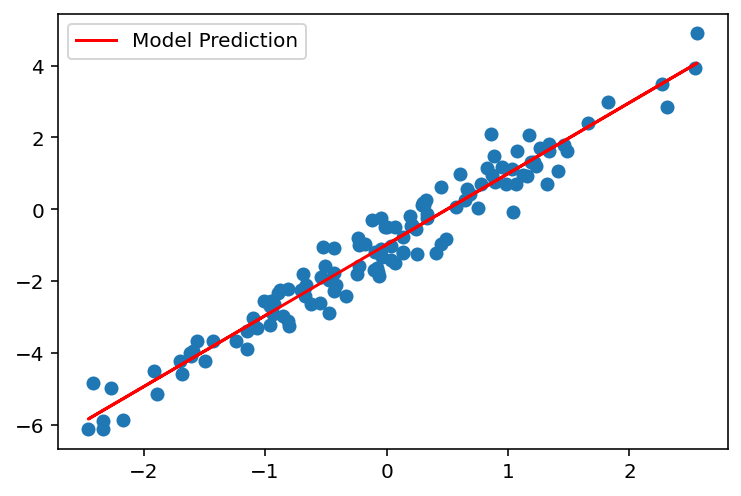

In [ ]:
import matplotlib.pyplot as plt

rng = jax.random.key(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();

# External Callbacks


- jax.pure_callback(): appropriate for pure functions: i.e. functions with no side effects.

- jax.experimental.io_callback(): appropriate for impure functions: e.g. functions which read or write data to disk.

- jax.debug.callback(): appropriate for functions that should reflect the execution behavior of the compiler.

In [ ]:
# @title Exploring pure_callback

import jax
import jax.numpy as jnp
import numpy as np

def f_host(x):
  # call a numpy (not jax.numpy) operation:
  return np.sin(x).astype(x.dtype)

def f(x):
  result_shape = jax.ShapeDtypeStruct(x.shape, x.dtype)
  return jax.pure_callback(f_host, result_shape, x)

x = jnp.arange(5.0)
print(f(x))
print(jax.jit(f)(x))
print(jax.vmap(f)(x))
def body_fun(_, x):
  return _, f(x)
jax.lax.scan(body_fun, None, jnp.arange(5.0))[1]
# Pure callbacks do not support JVP
# jax.grad(f)(x)

[ 0.          0.84147096  0.9092974   0.14112    -0.7568025 ]
[ 0.          0.84147096  0.9092974   0.14112    -0.7568025 ]
[ 0.          0.84147096  0.9092974   0.14112    -0.7568025 ]


<ipython-input-17-6c0ef8dea82e>:11: DeprecationWarning: The default behavior of pure_callback under vmap will soon change. Currently, the default behavior is to generate a sequential vmap (i.e. a loop), but in the future the default will be to raise an error. To keep the current default, set vmap_method='sequential'.
  return jax.pure_callback(f_host, result_shape, x)


Array([ 0.        ,  0.84147096,  0.9092974 ,  0.14112   , -0.7568025 ],      dtype=float32)

In [ ]:
def print_something():
  print('printing something')
  return np.int32(0)

@jax.jit
def f1():
  return jax.pure_callback(print_something, np.int32(0))
f1();

printing something


In [ ]:
@jax.jit
def f2():
  # the output of the callback is unused, and so the compiler notices this and eliminates the function call.
  jax.pure_callback(print_something, np.int32(0))
  return 1.0
f2();

In [ ]:
# @title Exploring io_callback
# functions that do have side-effects
from jax.experimental import io_callback
from functools import partial

global_rng = np.random.default_rng(0)

def host_side_random_like(x):
  """Generate a random array like x using the global_rng state"""
  # We have two side-effects here:
  # - printing the shape and dtype
  # - calling global_rng, thus updating its state
  # a side-effect of generating a random number in numpy is that the random state is updated
  print(f'generating {x.dtype}{list(x.shape)}')
  return global_rng.uniform(size=x.shape).astype(x.dtype)

@jax.jit
def numpy_random_like(x):
  # a callback to a global host-side numpy random generator
  return io_callback(host_side_random_like, x, x)

x = jnp.zeros(5)
print(numpy_random_like(x))

print("\nvmap\n", jax.vmap(numpy_random_like)(x))


@jax.jit
def numpy_random_like_ordered(x):
  return io_callback(host_side_random_like, x, x, ordered=True)
# Cannot `vmap` ordered IO callback.
# jax.vmap(numpy_random_like_ordered)(x)

def body_fun(_, x):
  return _, numpy_random_like_ordered(x)
print("\nscan\n", jax.lax.scan(body_fun, None, jnp.arange(5.0))[1])

# ValueError: IO callbacks do not support JVP.
# jax.grad(numpy_random_like)(x)

# if the callback is not dependent on a differentiated variable, it will execute:
# Unlike pure_callback, the compiler will not remove the callback execution in
# this case, even though the output of the callback is unused in the subsequent
# computation.
@jax.jit
def f(x):
  io_callback(lambda: print('hello'), None)
  return x

jax.grad(f)(1.0);


generating float32[5]
[0.6369617  0.26978672 0.04097353 0.01652764 0.8132702 ]

vmap
generating float32[]
 generating float32[]
generating float32[]
generating float32[]
generating float32[]
[0.91275555 0.60663575 0.72949654 0.543625   0.9350724 ]

scan
 generating float32[]
generating float32[]
generating float32[]
generating float32[]
generating float32[]
[0.81585354 0.0027385  0.8574043  0.03358557 0.72965544]
hello


In [ ]:
# @title Exploring debug.callback

from jax import debug

def log_value(x):
  # This could be an actual logging call; we'll use
  # print() for demonstration
  print("log:", x)

@jax.jit
def f(x):
  debug.callback(log_value, x)
  return x

f(1.0);

x = jnp.arange(5.0)
jax.vmap(f)(x);

jax.grad(f)(1.0);

In [ ]:
# @title Example: pure_callback with custom_jvp

# Gradient checkpointing with jax.checkpoint (jax.remat)

Use the jax.checkpoint() decorator (aliased as jax.remat()) with jax.grad() to control which intermediates are saved on the forward pass versus the recomputed intermediates on the backward pass, trading off memory and FLOPs.

In [ ]:
# If you don’t use jax.checkpoint(), the jax.grad(f)(x) forward pass stores
# Jacobian coefficients and other intermediates to use during the backward pass.
# These saved values are called residuals.
import jax
import jax.numpy as jnp

def g(W, x):
  y = jnp.dot(W, x)
  return jnp.sin(y)

def f(W1, W2, W3, x):
  x = g(W1, x)
  x = g(W2, x)
  x = g(W3, x)
  return x

W1 = jnp.ones((5, 4))
W2 = jnp.ones((6, 5))
W3 = jnp.ones((7, 6))
x = jnp.ones(4)

# Inspect the 'residual' values to be saved on the forward pass
# if you were to evaluate `jax.grad(f)(W1, W2, W3, x)`
from jax.ad_checkpoint import print_saved_residuals
jax.ad_checkpoint.print_saved_residuals(f, W1, W2, W3, x)

f32[5,4] from the argument W1
f32[6,5] from the argument W2
f32[7,6] from the argument W3
f32[4] from the argument x
f32[5] output of sin from <ipython-input-27-9b1bc8963ecf>:10:9 (g)
f32[5] output of cos from <ipython-input-27-9b1bc8963ecf>:10:9 (g)
f32[6] output of sin from <ipython-input-27-9b1bc8963ecf>:10:9 (g)
f32[6] output of cos from <ipython-input-27-9b1bc8963ecf>:10:9 (g)
f32[7] output of cos from <ipython-input-27-9b1bc8963ecf>:10:9 (g)


In [ ]:
#  only the inputs of a jax.checkpoint()-decorated function might be saved
def f2(W1, W2, W3, x):
  x = jax.checkpoint(g)(W1, x)
  x = jax.checkpoint(g)(W2, x)
  x = jax.checkpoint(g)(W3, x)
  return x

jax.ad_checkpoint.print_saved_residuals(f2, W1, W2, W3, x)

#  inputs to a jax.checkpoint()-decorated function may be saved, e.g. sin

f32[5,4] from the argument W1
f32[6,5] from the argument W2
f32[7,6] from the argument W3
f32[4] from the argument x
f32[5] output of sin from <ipython-input-27-9b1bc8963ecf>:10:9 (g)
f32[6] output of sin from <ipython-input-27-9b1bc8963ecf>:10:9 (g)


In [ ]:
# saves only the results of dot operations with no batch dimensions (since they
# are often FLOP-bound, and hence worth saving rather than recomputing)
f3 = jax.checkpoint(f, policy=jax.checkpoint_policies.dots_with_no_batch_dims_saveable)
jax.ad_checkpoint.print_saved_residuals(f3, W1, W2, W3, x)

f32[5,4] from the argument W1
f32[6,5] from the argument W2
f32[7,6] from the argument W3
f32[4] from the argument x
f32[5] output of reduce_precision from <ipython-input-27-9b1bc8963ecf>:9:6 (g)
f32[6] output of reduce_precision from <ipython-input-27-9b1bc8963ecf>:9:6 (g)
f32[7] output of reduce_precision from <ipython-input-27-9b1bc8963ecf>:9:6 (g)


In [ ]:
from jax.ad_checkpoint import checkpoint_name

def f4(W1, W2, W3, x):
  x = checkpoint_name(g(W1, x), name='a')
  x = checkpoint_name(g(W2, x), name='b')
  x = checkpoint_name(g(W3, x), name='c')
  return x

f4 = jax.checkpoint(f4, policy=jax.checkpoint_policies.save_only_these_names('a'))
jax.ad_checkpoint.print_saved_residuals(f4, W1, W2, W3, x)

f32[5,4] from the argument W1
f32[6,5] from the argument W2
f32[7,6] from the argument W3
f32[4] from the argument x
f32[5] output of reduce_precision from <ipython-input-30-fc0ed1c14b8d>:4:6 (f4)


# JAX Internals: primitives

## Using existing JAX primitives

In [ ]:
from jax import lax
from jax._src import api

def multiply_add_lax(x, y, z):
  """Implementation of multiply-add using the `jax.lax` primitives."""
  return lax.add(lax.mul(x, y), z)


def square_add_lax(a, b):
  """A square-add function using the newly defined multiply-add."""
  return multiply_add_lax(a, a, b)

print("square_add_lax = ", square_add_lax(2., 10.))
# Differentiate w.r.t. the first argument
print("grad(square_add_lax) = ", api.grad(square_add_lax, argnums=0)(2.0, 10.))

In [ ]:
#@title Helper functions (execute this cell)
import functools
import traceback

_indentation = 0
def _trace(msg=None):
    """Print a message at current indentation."""
    if msg is not None:
        print("  " * _indentation + msg)

def _trace_indent(msg=None):
    """Print a message and then indent the rest."""
    global _indentation
    _trace(msg)
    _indentation = 1 + _indentation

def _trace_unindent(msg=None):
    """Unindent then print a message."""
    global _indentation
    _indentation = _indentation - 1
    _trace(msg)

def trace(name):
  """A decorator for functions to trace arguments and results."""

  def trace_func(func):  # pylint: disable=missing-docstring
    def pp(v):
        """Print certain values more succinctly"""
        vtype = str(type(v))
        if "jax._src.xla_bridge._JaxComputationBuilder" in vtype:
            return "<JaxComputationBuilder>"
        elif "jaxlib.xla_extension.XlaOp" in vtype:
            return "<XlaOp at 0x{:x}>".format(id(v))
        elif ("partial_eval.JaxprTracer" in vtype or
              "batching.BatchTracer" in vtype or
              "ad.JVPTracer" in vtype):
            return "Traced<{}>".format(v.aval)
        elif isinstance(v, tuple):
            return "({})".format(pp_values(v))
        else:
            return str(v)
    def pp_values(args):
        return ", ".join([pp(arg) for arg in args])

    @functools.wraps(func)
    def func_wrapper(*args):
      _trace_indent("call {}({})".format(name, pp_values(args)))
      res = func(*args)
      _trace_unindent("|<- {} = {}".format(name, pp(res)))
      return res

    return func_wrapper

  return trace_func

class expectNotImplementedError(object):
  """Context manager to check for NotImplementedError."""
  def __enter__(self): pass
  def __exit__(self, type, value, tb):
    global _indentation
    _indentation = 0
    if type is NotImplementedError:
      print("\nFound expected exception:")
      traceback.print_exc(limit=3)
      return True
    elif type is None:  # No exception
      assert False, "Expected NotImplementedError"
    else:
      return False

In [ ]:
import jax.numpy as jnp
import numpy as np

@trace("multiply_add_numpy")
def multiply_add_numpy(x, y, z):
    return jnp.add(jnp.multiply(x, y), z)

@trace("square_add_numpy")
def square_add_numpy(a, b):
    return multiply_add_numpy(a, a, b)

print("\nNormal evaluation:")
print("square_add_numpy = ", square_add_numpy(2., 10.))
print("\nGradient evaluation:")
print("grad(square_add_numpy) = ", api.grad(square_add_numpy)(2.0, 10.))

## Defining new JAX primitives

In [ ]:
from jax import core

multiply_add_p = core.Primitive("multiply_add")  # Create the primitive

@trace("multiply_add_prim")
def multiply_add_prim(x, y, z):
  """The JAX-traceable way to use the JAX primitive.

  Note that the traced arguments must be passed as positional arguments
  to `bind`.
  """
  return multiply_add_p.bind(x, y, z)

@trace("square_add_prim")
def square_add_prim(a, b):
  """A square-add function implemented using the new JAX-primitive."""
  return multiply_add_prim(a, a, b)

In [ ]:
@trace("multiply_add_impl")
def multiply_add_impl(x, y, z):
  """Concrete implementation of the primitive.

  This function does not need to be JAX traceable.

  Args:
    x, y, z: The concrete arguments of the primitive. Will only be called with
      concrete values.

  Returns:
    the concrete result of the primitive.
  """
  # Note: you can use the ordinary (non-JAX) NumPy, which is not JAX-traceable.
  return np.add(np.multiply(x, y), z)

# Now, register the primal implementation with JAX:
multiply_add_p.def_impl(multiply_add_impl)

In [ ]:
from jax import core

@trace("multiply_add_abstract_eval")
def multiply_add_abstract_eval(xs, ys, zs):
  """Abstract evaluation of the primitive.

  This function does not need to be JAX traceable. It will be invoked with
  abstractions of the actual arguments

  Args:
    xs, ys, zs: Abstractions of the arguments.

  Result:
    a ShapedArray for the result of the primitive.
  """
  assert xs.shape == ys.shape
  assert xs.shape == zs.shape
  return core.ShapedArray(xs.shape, xs.dtype)

# Now, register the abstract evaluation with JAX:
multiply_add_p.def_abstract_eval(multiply_add_abstract_eval)

In [ ]:
from jax._src.lib.mlir.dialects import hlo

@trace("multiply_add_lowering")
def multiply_add_lowering(ctx, xc, yc, zc):
  """The compilation to XLA of the primitive.

  Given an mlir.ir.Value for each argument, return the mlir.ir.Values for
  the results of the function.

  Does not need to be a JAX-traceable function.
  """
  return [hlo.AddOp(hlo.MulOp(xc, yc), zc).result]

# Now, register the lowering rule with JAX.
# For GPU, refer to the https://jax.readthedocs.io/en/latest/Custom_Operation_for_GPUs.html
from jax.interpreters import mlir

mlir.register_lowering(multiply_add_p, multiply_add_lowering, platform='cpu')

In [ ]:
from jax.interpreters import ad

@trace("multiply_add_value_and_jvp")
def multiply_add_value_and_jvp(arg_values, arg_tangents):
  """Evaluates the primal output and the tangents (Jacobian-vector product).

  Given values of the arguments and perturbation of the arguments (tangents),
  compute the output of the primitive and the perturbation of the output.

  This method must be JAX-traceable. JAX may invoke it with abstract values
  for the arguments and tangents.

  Args:
    arg_values: A tuple of arguments
    arg_tangents: A tuple with the tangents of the arguments. The tuple has
      the same length as the arg_values. Some of the tangents may also be the
      special value `ad.Zero` to specify a zero tangent

  Returns:
     A pair of the primal output and the tangent.
  """
  x, y, z = arg_values
  xt, yt, zt = arg_tangents
  _trace("Primal evaluation:")
  # Now, you have a JAX-traceable computation of the output.
  # Normally, you can use the multiply add (`ma`) primitive itself to compute the primal output.
  primal_out = multiply_add_prim(x, y, z)

  _trace("Tangent evaluation:")
  # You must use a JAX-traceable way to compute the tangent. It turns out that
  # the output tangent can be computed as (xt * y + x * yt + zt),
  # which you can implement in a JAX-traceable way using the same "multiply_add_prim" primitive.

  # You do need to deal specially with `Zero`. Here, you just turn it into a
  # proper tensor of 0s (of the same shape as 'x').
  # An alternative would be to check for `Zero` and perform algebraic
  # simplification of the output tangent computation.
  def make_zero(tan):
    return lax.zeros_like_array(x) if type(tan) is ad.Zero else tan

  output_tangent = multiply_add_prim(make_zero(xt), y, multiply_add_prim(x, make_zero(yt), make_zero(zt)))
  return (primal_out, output_tangent)

# Register the forward differentiation rule with JAX:
ad.primitive_jvps[multiply_add_p] = multiply_add_value_and_jvp

# JAX internals: The jaxpr language

if one wants to understand how JAX works internally, or to make use of the result of JAX tracing, it is useful to understand jaxprs.

# Jax - The Sharp Bits

In [ ]:
# @title Pure functions: the proper way to use JAX is to use it only on functionally pure Python functions.

# Pure functions: all the input data is passed through the function parameters,
# all the results are output through the function results. A pure function will
# always return the same result if invoked with the same inputs.

# Here are some examples of functions that are not functionally pure for which
# JAX behaves differently than the Python interpreter. Note that these behaviors
# are not guaranteed by the JAX system; the proper way to use JAX is to use it
# only on functionally pure Python functions.

def impure_print_side_effect(x):
  print("Executing function")  # This is a side-effect
  return x

# The side-effects appear during the first run
print ("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compilation of the function
print ("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jit(impure_print_side_effect)(jnp.array([5.])))


g = 0.
def impure_uses_globals(x):
  return x + g

# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))
g = 10.  # Update the global

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(jnp.array([4.])))

g = 0.
def impure_saves_global(x):
  global g
  g = x
  return x

# JAX runs once the transformed function with special Traced values for arguments
print ("First call: ", jit(impure_saves_global)(4.))
print ("Saved global: ", g)  # Saved global has an internal JAX value

INFO:2024-11-09 16:18:28,124:jax._src.xla_bridge:906: Unable to initialize backend 'rocm': Your process properly initialized the GPU backend, but //learning/brain/research/jax:gpu_support is not linked in. You most likely should add that build dependency to your program.
INFO:2024-11-09 16:18:30,680:jax._src.xla_bridge:906: Unable to initialize backend 'pathways': Could not initialize backend 'pathways'
INFO:2024-11-09 16:18:30,680:jax._src.xla_bridge:906: Unable to initialize backend 'mock_tpu': Must pass --mock_tpu_platform flag to initialize the mock_tpu backend


Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [5.]


In [ ]:
g = 0.
def impure_saves_global(x):
  global g
  g = x
  return x

# JAX runs once the transformed function with special Traced values for arguments
print ("First call: ", jit(impure_saves_global)(4.))
print ("Saved global: ", g)  # Saved global has an internal JAX value
print ("Second call: ", jit(impure_saves_global)(4.))
print ("Saved global: ", g)  # Saved global has an internal JAX value

First call:  4.0
Saved global:  Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace>
Second call:  4.0
Saved global:  Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace>


In [ ]:
# A Python function can be functionally pure even if it actually uses stateful
# objects internally, as long as it does not read or write external state:
def pure_uses_internal_state(x):
  state = dict(even=0, odd=0)
  for i in range(10):
    state['even' if i % 2 == 0 else 'odd'] += x
  return state['even'] + state['odd']

print(jit(pure_uses_internal_state)(5.))

50.0


In [ ]:
# It is not recommended to use iterators in any JAX function you want to jit or in any control-flow primitive. The reason is that an iterator is a python object which introduces state to retrieve the next element. Therefore, it is incompatible with JAX functional programming model. In the code below, there are some examples of incorrect attempts to use iterators with JAX. Most of them return an error, but some give unexpected results.

import jax.numpy as jnp
from jax import make_jaxpr
from jax import lax

# lax.fori_loop
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i,x: x+array[i], 0)) # expected result 45
iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i,x: x+next(iterator), 0)) # unexpected result 0

# lax.scan
def func11(arr, extra):
    ones = jnp.ones(arr.shape)
    def body(carry, aelems):
        ae1, ae2 = aelems
        return (carry + ae1 * ae2 + extra, carry)
    return lax.scan(body, 0., (arr, ones))
make_jaxpr(func11)(jnp.arange(16), 5.)
# make_jaxpr(func11)(iter(range(16)), 5.) # throws error

# lax.cond
array_operand = jnp.array([0.])
lax.cond(True, lambda x: x+1, lambda x: x-1, array_operand)
iter_operand = iter(range(10))
# lax.cond(True, lambda x: next(x)+1, lambda x: next(x)-1, iter_operand) # throws error

45
0


In [ ]:
# @title In-place updates

# Numpy works, but Jax does not work.
import numpy as np

numpy_array = np.zeros((3,3), dtype=np.float32)
print("original array:")
print(numpy_array)

# In place, mutating update
numpy_array[1, :] = 1.0
print("updated array:")
print(numpy_array)


print("\n Jax")
# %xmode Minimal
jax_array = jnp.zeros((3,3), dtype=jnp.float32)

# In place update of JAX's array will yield an error!
# jax_array[1, :] = 1.0

# Out of place
updated_array = jax_array.at[1, :].set(1.0)
print("updated array:\n", updated_array)
print("original array unchanged:\n", jax_array)

original array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]

 Jax
updated array:
 [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]
original array unchanged:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
# @title Out-of-bounds indexing: think of out-of-bounds indexing in JAX as a case of undefined behavior.

# Numpy will report an error
# np.arange(10)[11]

# raising an error from code running on an accelerator can be difficult or impossible
# the last value is returned for
print(jnp.arange(10)[11])

# customize the behavior
print(jnp.arange(10.0).at[11].get(mode='fill', fill_value=jnp.nan))

9
nan


In [ ]:
# @title Non-array inputs: NumPy vs. JAX: passing lists or tuples to traced functions can lead to silent performance degradation that might otherwise be difficult to detect.

print(np.sum([1, 2, 3]))
# Error: jnp sum requires ndarray or scalar arguments
# jnp.sum([1, 2, 3])
x = [1, 2, 3]
print(jnp.sum(jnp.array(x)))


6
6


In [ ]:
# @title Random numbers

# Numpy: it’s hard to reason about how it’s being used and updated across different threads, processes, and devices
print(np.random.random())
print(np.random.random())
print(np.random.random())

np.random.seed(0)
rng_state = np.random.get_state()
# print(rng_state)

_ = np.random.uniform()
rng_state = np.random.get_state()
#print(rng_state)
# --> ('MT19937', array([2443250962, 1093594115, 1878467924,
#       ..., 2648828502, 1678096082], dtype=uint32), 2, 0, 0.0)

# Let's exhaust the entropy in this PRNG statevector
for i in range(311):
  _ = np.random.uniform()
rng_state = np.random.get_state()
#print(rng_state)
# --> ('MT19937', array([2443250962, 1093594115, 1878467924,
#       ..., 2648828502, 1678096082], dtype=uint32), 624, 0, 0.0)

# Next call iterates the RNG state for a new batch of fake "entropy".
_ = np.random.uniform()
rng_state = np.random.get_state()
# print(rng_state)
# --> ('MT19937', array([1499117434, 2949980591, 2242547484,
#      4162027047, 3277342478], dtype=uint32), 2, 0, 0.0)

# Jax
key = random.key(0)
key

print(random.normal(key, shape=(1,)))
print(key)
# No no no! the same value
print(random.normal(key, shape=(1,)))
print(key)

print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print(r"    \---SPLIT --> new key   ", key)
print(r"             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

key, *subkeys = random.split(key, 4)
for subkey in subkeys:
  print(random.normal(subkey, shape=(1,)))

0.08960303423860538
0.6720478073539145
0.24536720985284477


Array((), dtype=key<fry>) overlaying:
[0 0]

## Control flow

In [ ]:
# @title Python control_flow + autodiff

def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

print(grad(f)(2.))  # ok!
print(grad(f)(4.))  # ok!

12.0
-4.0


In [ ]:
# @title Python control flow + JIT

@jit
def f(x):
  for i in range(3):
    x = 2 * x
  return x

print(f(3))

@jit
def g(x):
  y = 0.
  for i in range(x.shape[0]):
    y = y + x[i]
  return y

print(g(jnp.array([1., 2., 3.])))

24


In [ ]:
@jit
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

# This will fail!
# When we jit-compile a function, we usually want to compile a version of the function that works for many different argument values, so that we can cache and reuse the compiled code. That way we don’t have to re-compile on each function evaluation.
# f(2)

# specify to trace on concrete values of some arguments
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f = jit(f, static_argnums=(0,))

print(f(2.))

def f(x, n):
  y = 0.
  for i in range(n):
    y = y + x[i]
  return y

f = jit(f, static_argnums=(1,))

f(jnp.array([2., 3., 4.]), 2)

12.0


In [ ]:
def example_fun(length, val):
  return jnp.ones((length,)) * val
# un-jit'd works fine
print(example_fun(5, 4))

bad_example_jit = jit(example_fun)
# this will fail:
# bad_example_jit(10, 4)

# static_argnums tells JAX to recompile on changes at these argument positions:
good_example_jit = jit(example_fun, static_argnums=(0,))
# first compile
print(good_example_jit(10, 4))
# recompiles
print(good_example_jit(5, 4))

In [ ]:
# @title Structured control flow primitives

def cond(pred, true_fun, false_fun, operand):
  if pred:
    return true_fun(operand)
  else:
    return false_fun(operand)

from jax import lax

operand = jnp.array([0.])
print(lax.cond(True, lambda x: x+1, lambda x: x-1, operand))
# --> array([1.], dtype=float32)
print(lax.cond(False, lambda x: x+1, lambda x: x-1, operand))
# --> array([-1.], dtype=float32)

def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val

init_val = 0
cond_fun = lambda x: x < 10
body_fun = lambda x: x+1
lax.while_loop(cond_fun, body_fun, init_val)
# --> array(10, dtype=int32)

def fori_loop(start, stop, body_fun, init_val):
  val = init_val
  for i in range(start, stop):
    val = body_fun(i, val)
  return val

init_val = 0
start = 0
stop = 10
body_fun = lambda i,x: x+i
lax.fori_loop(start, stop, body_fun, init_val)
# --> array(45, dtype=int32)

[1.]
[-1.]


## Dynamic shapes

In [ ]:
def nansum(x):
  mask = ~jnp.isnan(x)  # boolean mask selecting non-nan values
  x_without_nans = x[mask]
  return x_without_nans.sum()

x = jnp.array([1, 2, jnp.nan, 3, 4])
print(nansum(x))

# fails because the size of x_without_nans is dependent on the values within x, which is another way of saying its size is dynamic
# jax.jit(nansum)(x)

@jax.jit
def nansum_2(x):
  mask = ~jnp.isnan(x)  # boolean mask selecting non-nan values
  return jnp.where(mask, x, 0).sum()

print(nansum_2(x))

# Debugging NaNs

## Double (64bit) precision

## Miscellaneous divergences from NumPy